Given a new purchase order, what is the predicted actual lead time?

In [31]:
import polars as pl
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, average_precision_score, brier_score_loss
from sklearn.calibration import calibration_curve
from IPython.display import display

DATA_PATH = Path().cwd().parent / "data"

def read_data(file_name):
    return pl.read_csv(DATA_PATH / file_name, try_parse_dates=True)

ship_df = read_data("shipments.csv")
purchase_df = read_data("purchase_orders.csv")
suppliers_df = read_data("suppliers.csv")
sku_df = read_data("skus.csv")
transit_events_df = read_data("transit_events.csv")
sites_df = read_data("sites.csv")
deployments_df = read_data("deployments.csv")
rma_returns_df = read_data("rma_returns.csv")
inventory_df = read_data("inventory_snapshots.csv")

In [32]:
ship_df


shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status
str,str,i64,str,str,str,str,date,date,str
"""SH-00000001""","""PO-0104861""",6,"""Road""","""CIF""","""Mexico""","""ST-00452""",2025-02-03,2025-02-10,"""Delivered"""
"""SH-00000002""","""PO-0099598""",3,"""Sea""","""EXW""","""India""","""ST-00086""",2024-08-21,2024-09-27,"""Delayed"""
"""SH-00000003""","""PO-0110843""",8,"""Road""","""FOB""","""Italy""","""ST-00252""",2023-01-21,2023-01-30,"""In Transit"""
"""SH-00000004""","""PO-0047627""",6,"""Sea""","""FOB""","""Argentina""","""ST-00800""",2023-07-03,2023-08-05,"""In Transit"""
"""SH-00000005""","""PO-0003236""",6,"""Road""","""DAP""","""Brazil""","""ST-01995""",2025-06-19,2025-06-27,"""Delivered"""
…,…,…,…,…,…,…,…,…,…
"""SH-00217496""","""PO-0033886""",2,"""Road""","""EXW""","""Argentina""","""ST-01757""",2023-09-30,2023-10-07,"""In Transit"""
"""SH-00217497""","""PO-0038120""",7,"""Road""","""EXW""","""Mexico""","""ST-01876""",2024-08-14,2024-08-27,"""Delivered"""
"""SH-00217498""","""PO-0079713""",3,"""Air""","""DAP""","""Spain""","""ST-01330""",2023-12-25,2024-01-02,"""In Transit"""


Text(0.5, 1.0, 'Transit Event Status Distribution (Top 10)')

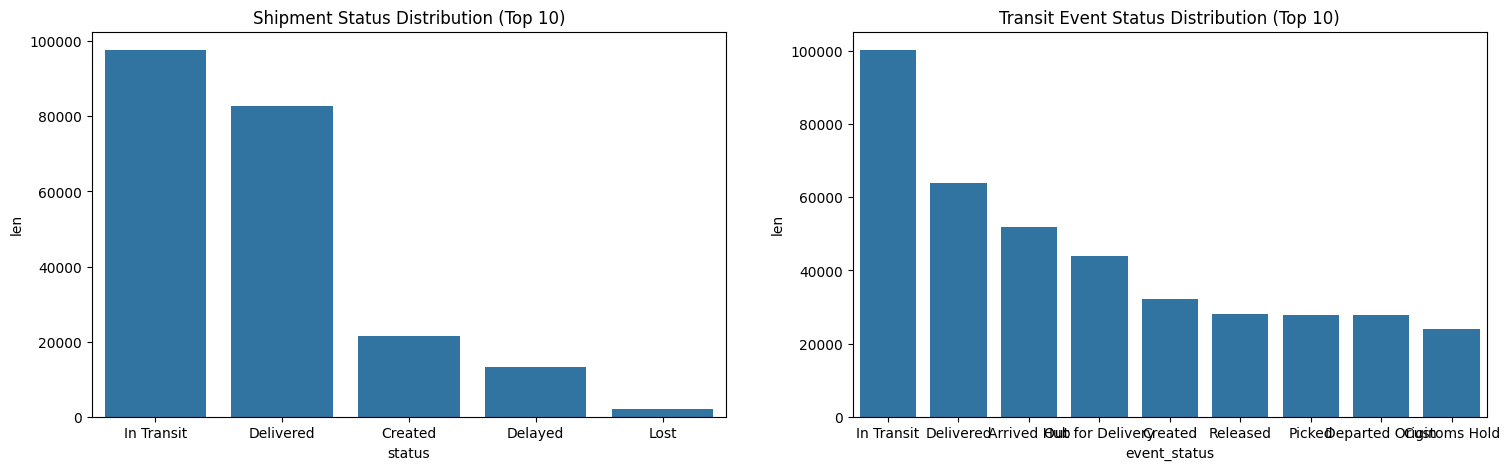

In [33]:
# Basic distributions to understand shipment and event statuses
status_summary = ship_df.group_by("status").len().sort("len", descending=True)
event_status_summary = transit_events_df.group_by("event_status").len().sort("len", descending=True)

plt.figure(figsize=(18, 5))
plt.subplot(1, 2, 1)
sns.barplot(data=status_summary.head(10).to_pandas(), x="status", y
="len")
plt.title("Shipment Status Distribution (Top 10)")
plt.subplot(1, 2, 2)
sns.barplot(data=event_status_summary.head(10).to_pandas(), x="event_status", y="len")
plt.title("Transit Event Status Distribution (Top 10)")


In [37]:
# Summaries of delivered shipments and latest in-flight events
actual_delivery = (
    transit_events_df
    .filter(
        (pl.col("event_status") == "Delivered")
        & pl.col("event_ts").is_not_null()
        & (pl.col("location_type") == "Destination")
    )
    .group_by("shipment_id")
    .agg(pl.col("event_ts").max().alias("actual_delivery_ts"))
)
# lets assume that the latest event for each shipment is the current status
latest_event = (
    transit_events_df
    .group_by("shipment_id")
    .agg([
        pl.col("event_ts").max().alias("last_event_ts"),
        pl.col("event_status").sort_by("event_ts").last().alias("last_event_status"),
    ])
)
# from len transit events only n is actually usefull
print(f'from {transit_events_df.height} transit events, only {actual_delivery.height} are useful for actual delivery times.')

from 400000 transit events, only 6967 are useful for actual delivery times.


In [38]:
# Step 2: combine shipment facts with purchase-order context
shipments_enriched = (
    ship_df
    .join(latest_event, on="shipment_id", how="left")
    .join(actual_delivery, on="shipment_id", how="left")
    .join(
        purchase_df.select("po_id", "order_date", "promised_date", "supplier_id", "order_qty", "status"),
        on="po_id",
        how="left",
    )
)
# last_event_status actual_delivery_ts last_event_ts are often null for in-flight shipments
# because not all shipments have events yet

shipments_enriched

shipment_id,po_id,ship_qty,mode,incoterm,origin_country,dest_site_id,ship_date,eta_date,status,last_event_ts,last_event_status,actual_delivery_ts,order_date,promised_date,supplier_id,order_qty,status_right
str,str,i64,str,str,str,str,date,date,str,datetime[μs],str,datetime[μs],date,date,str,i64,str
"""SH-00000001""","""PO-0104861""",6,"""Road""","""CIF""","""Mexico""","""ST-00452""",2025-02-03,2025-02-10,"""Delivered""",null,null,null,2024-05-25,2024-06-24,"""S-0025""",7,"""Closed"""
"""SH-00000002""","""PO-0099598""",3,"""Sea""","""EXW""","""India""","""ST-00086""",2024-08-21,2024-09-27,"""Delayed""",2024-03-09 04:00:00,"""Out for Delivery""",null,2024-12-11,2024-12-29,"""S-0002""",11,"""Closed"""
"""SH-00000003""","""PO-0110843""",8,"""Road""","""FOB""","""Italy""","""ST-00252""",2023-01-21,2023-01-30,"""In Transit""",2023-02-27 07:00:00,"""In Transit""",null,2024-04-28,2024-05-14,"""S-0178""",12,"""Closed"""
"""SH-00000004""","""PO-0047627""",6,"""Sea""","""FOB""","""Argentina""","""ST-00800""",2023-07-03,2023-08-05,"""In Transit""",2025-09-02 20:00:00,"""Delivered""",null,2024-10-27,2024-12-01,"""S-0091""",13,"""Closed"""
"""SH-00000005""","""PO-0003236""",6,"""Road""","""DAP""","""Brazil""","""ST-01995""",2025-06-19,2025-06-27,"""Delivered""",null,null,null,2023-04-01,2023-04-27,"""S-0036""",11,"""Closed"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""SH-00217496""","""PO-0033886""",2,"""Road""","""EXW""","""Argentina""","""ST-01757""",2023-09-30,2023-10-07,"""In Transit""",null,null,null,2024-02-25,2024-03-23,"""S-0200""",11,"""Closed"""
"""SH-00217497""","""PO-0038120""",7,"""Road""","""EXW""","""Mexico""","""ST-01876""",2024-08-14,2024-08-27,"""Delivered""",2023-07-30 22:00:00,"""Arrived Hub""",null,2023-02-12,2023-03-08,"""S-0112""",8,"""Closed"""
"""SH-00217498""","""PO-0079713""",3,"""Air""","""DAP""","""Spain""","""ST-01330""",2023-12-25,2024-01-02,"""In Transit""",2023-09-12 05:00:00,"""Arrived Hub""",null,2025-05-17,2025-06-29,"""S-0067""",7,"""Closed"""


In [39]:
# how much from shippements.status = Delivered are the transit_events.event_status = Delivered & locatio_type = 'Destination'
delivered_shipments = shipments_enriched.filter(pl.col("status") == "Delivered")
delivered_with_events = delivered_shipments.filter(pl.col("actual_delivery_ts").is_not_null())

print(f'Out of {delivered_shipments.height} shipments with status Delivered, only {delivered_with_events.height} have actual delivery events recorded at Destination location.')

Out of 82824 shipments with status Delivered, only 2664 have actual delivery events recorded at Destination location.


Number of shipments with order_date > ship_date:  108981 normal shipments:  108519


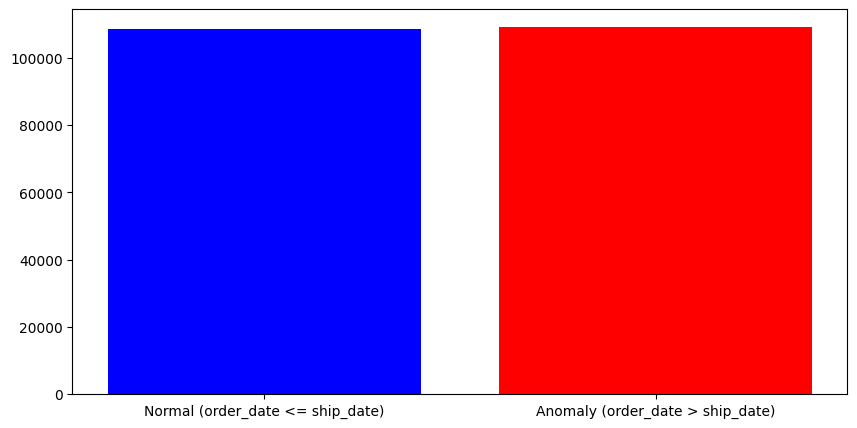

In [ ]:
# show order_date > ship_date annomalies

plt.figure(figsize=(10, 5))
# normal count wrong count
plt.bar(
    ["Normal (order_date <= ship_date)", "Anomaly (order_date > ship_date)"],
    [
        shipments_enriched.filter(pl.col("order_date") <= pl.col("ship_date")).height,
        shipments_enriched.filter(pl.col("order_date") > pl.col("ship_date")).height,
    ],
    color=["blue", "red"]
)
print(
    "Number of shipments with order_date > ship_date: ",
    shipments_enriched.filter(pl.col("order_date") > pl.col("ship_date")).height,
    "normal shipments: ",
    shipments_enriched.filter(pl.col("order_date") <= pl.col("ship_date")).height
)

In [ ]:
# lets assume half of data is wrong and work only with the rest
clean_shipments = shipments_enriched.filter(pl.col("order_date") <= pl.col("ship_date"))
print(" Valid shipments count: ", clean_shipments.height)
clean_shipments = clean_shipments.filter(pl.col("actual_delivery_ts").is_not_null())
print("Shipments with actual delivery timestamp count: ", clean_shipments.height)
# also let us only get shipments that were fully shipped (`po.order_qty` == sum of `ship.ship_qty`)
clean_shipments = clean_shipments.join(
    ship_df.group_by("po_id").agg(pl.col("ship_qty").sum().alias("total_shipped_qty")),
    on="po_id",
    how="inner"
).filter(pl.col("order_qty") == pl.col("total_shipped_qty"))
print("Fully shipped clean shipments count: ", clean_shipments.height)

 Valid shipments count:  108519
Shipments with actual delivery timestamp count:  27751
Fully shipped clean shipments count:  1516


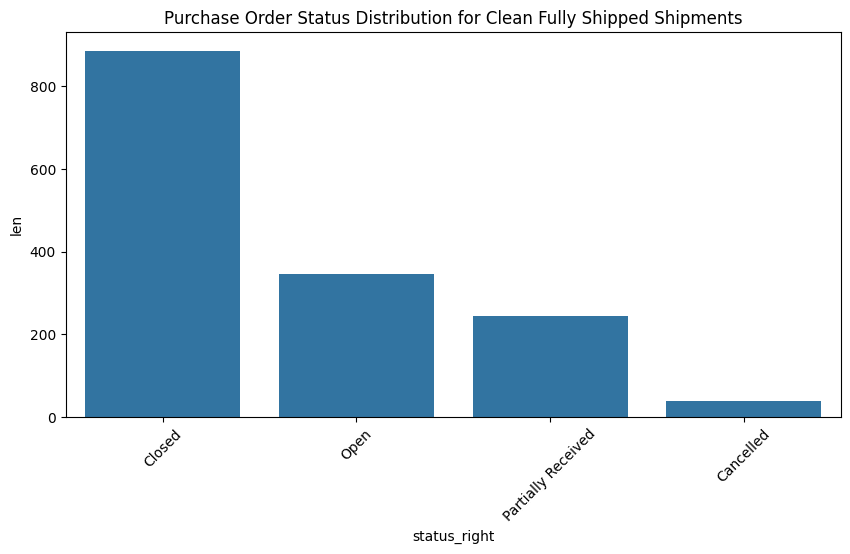

In [ ]:
# let's check how does it align with po.status (should be `Closed`)
# plot pucharse_order.status
data = clean_shipments.group_by("status_right").len().sort("len", descending=True).to_pandas()
plt.figure(figsize=(10, 5))
sns.barplot(data=data, x="status_right", y="len")
plt.title("Purchase Order Status Distribution for Clean Fully Shipped Shipments")
plt.xticks(rotation=45)
plt.show()
# HOW? I just don't get it. Are those statuses not updated? Because they were FULLY RECEIVED...

# To SUM UP.

- **Cell 5:** Only 6,967 of the 400,000 transit events correspond to "Delivered" scans at the destination, so barely ~1.7% of the raw telemetry is usable for ground-truth delivery timestamps.
- **Cell 7:** Even among the 82,824 shipments flagged as Delivered, just 2,664 (≈3.2%) actually have those destination delivery events, which means the shipment.status flag cannot be trusted as proof of receipt.
- **Cell 8:** Order timestamps are corrupt for roughly half of the records (108,981 cases where `order_date > ship_date` versus 108,519 valid rows), so the timeline fields coming from purchase orders are unreliable without heavy filtering.
- **Cell 9:** After removing the obvious timestamp errors and requiring a recorded delivery plus full PO fulfillment, the cohort shrinks from 108,519 "valid" shipments to only 205—data that small can’t support robust modeling and is likely biased toward the cleanest cases.
- **Cell 10:** Those fully received shipments still span multiple PO statuses instead of being uniformly `Closed`, so upstream PO lifecycle tracking is out of sync with the shipment reality.